In [19]:
using Revise
using Bilevel

using RigidBodyDynamics
using Plots
gr(size=(500,500), html_output_format=:png);

In [2]:
urdf = joinpath("..", "urdf", "ball.urdf")
mechanism = parse_urdf(Float64, urdf)
body = findbody(mechanism, "ball")
basejoint = joint_to_parent(body, mechanism)
floatingjoint = Joint(basejoint.name, frame_before(basejoint), frame_after(basejoint), QuaternionFloating{Float64}())
replace_joint!(mechanism, basejoint, floatingjoint)
position_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
velocity_bounds(floatingjoint) .= RigidBodyDynamics.Bounds(-100, 100)
μ = 0.5
motion_type = :xyz
point = Point3D(default_frame(findbody(mechanism, "floor")), [0.,0.,0.])
normal = FreeVector3D(default_frame(findbody(mechanism, "floor")), [0.,0.,1.])
hs = HalfSpace(point, normal)
floor = Obstacle(hs, μ, motion_type)
obstacles = [floor]
env = parse_contacts(mechanism, urdf, obstacles)
x0 = MechanismState(mechanism)
Δt = 0.005;

In [13]:
N = 25

traj_data = get_traj_data(mechanism,env,Δt,N,false)

x_start = zeros(traj_data.num_q+traj_data.num_v)
x_start[1] = 1.
add_constraint!(traj_data, xi -> xi - x_start, 1)

x_goal = zeros(traj_data.num_q+traj_data.num_v)
x_goal[1] = 1.
x_goal[5] = 1.
add_constraint!(traj_data, xi -> xi - x_goal, N)

xopt = Bilevel.trajopt_snopt(traj_data)

Finished successfully: optimality conditions satisfied


26×25 Array{Float64,2}:
 1.0    1.0            1.0          …     1.0             1.0        
 0.0    0.0            0.0                0.0             0.0        
 0.0    0.0            6.46235e-27        0.0             0.0        
 0.0    0.0            0.0                0.0             0.0        
 0.0    0.01           0.0291304          1.0             1.0        
 0.0    0.0            7.42892e-15  …     1.225e-13       0.0        
 0.0    5.59628e-20   -8.41941e-20        0.0             0.0        
 0.0    0.0            0.0                0.0             0.0        
 0.0    0.0            1.24077e-24        1.24077e-24     0.0        
 0.0    0.0            0.0                0.0             0.0        
 0.0    2.0            3.82609      …     2.0             0.0        
 0.0   -2.58494e-26   -5.14253e-13       -5.44832e-13     0.0        
 0.0   -5.5513e-17     8.15814e-17        6.76608e-17     0.0        
 0.0    0.0            0.0                0.0             0.0     

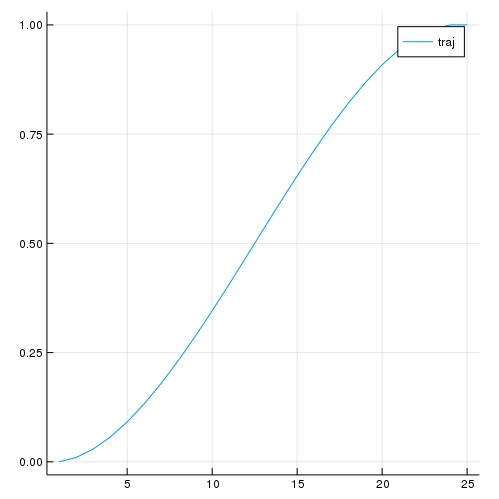

In [20]:
ts = cumsum([Δt for i in 1:N]);
j = 5
plot(xopt[j,:],label="traj")